# GWTC-3 Parameter Estimation 

GWTC-3 is the "third gravitational wave transient catalog" from the [LIGO](https://www.ligo.org/), [Virgo](https://www.virgo-gw.eu/), and [KAGRA](https://gwcenter.icrr.u-tokyo.ac.jp/en/) (LVK) Collaborations.
[GWTC-3](https://ligo.org/science/Publication-O3bCatalog/) updates the previous catalogs ([GWTC-1](https://ligo.org/science/Publication-O2Catalog/), [GWTC-2](https://ligo.org/science/Publication-O3aCatalog/), [GWTC-2.1](https://ligo.org/science/Publication-O3aFinalCatalog/)) with merger events observed during the second half of Observing Run 3 (O3b) which lasted from 1st November 2019 to 27th March 2020. 

The events listed in GWTC-3 are binary mergers between [black holes](https://en.wikipedia.org/wiki/Black_hole) and [neutron stars](https://en.wikipedia.org/wiki/neutron_star). 
Both black holes and neutron stars are classified as [compact objects](https://en.wikipedia.org/wiki/Compact_star). 
The LVK detectors are sensitive to three different types of compact binary mergers:

- Binary black hole (BBH) merger
- Binary neutron star (BNS) merger
- Neutron star - black hole (NSBH) merger

However, sometimes we are not totally confident which category a signal falls into - more about that later. 

All the data used in this notebook can be found from the [Gravitational Wave Open Science Centre (GWOSC)](https://www.gw-openscience.org) For more information on gravitational wave data and GWTC-3 have a look at:
- The [data release for the detector strain data](https://www.gw-openscience.org/GWTC-3/)
- The [data release for the parameter estimation samples](https://doi.org/10.5281/zenodo.5546662)
- The [GWTC-3 science summary](https://ligo.org/science/Publication-O3bCatalog/)
- The [GWTC-3 catalog paper](https://dcc.ligo.org/LIGO-P2000318/public)
- The GWTC-3 companion papers on [Population Properties](https://dcc.ligo.org/LIGO-P2100239/public) and [Cosmological Constraints](https://dcc.ligo.org/LIGO-P2100185/public)
- The [GWOSC Open Data Workshop](https://www.gw-openscience.org/static/workshop4/index.html)
- The [LIGO Magazine](https://www.ligo.org/magazine/) article [GWTC-3: Building a gravitational-wave catalog](https://www.ligo.org/magazine/LIGO-magazine-issue20.pdf#page=6).

This notebook is part of the GWTC-3 data release. 
It shows you how to read and plot parameter estimation results from [the parameter estimation data release](https://doi.org/10.5281/zenodo.5546662).

## Hold on! What is parameter estimation?

After detecting a gravitational wave signal, we would like to learn about what kind of compact object produced the signal. We can then answer questions like:

- What type of source was it likely to be? BBH, BNS, NSBH or MassGap.
- How massive were the black holes or neutron stars that collided? 
- Which direction on the sky did the signal come from?

The properties (or parameters) of the merging objects decide the shape of the gravitational waveform signal. 
Parameter estimation is a detailed analysis of the [shape of the signal waveform](https://www.ligo.org/magazine/LIGO-magazine-issue-8-extended.pdf#page=6). We compare many possible waveforms to the observed signal and find credible ranges for the parameters of the source. 


There are two types of parameters that describe a gravitational wave signal. 

- **Intrinsic** parameters are properties of the binary itself, including the masses and spins of the compact objects. 
- **Extrinsic** parameters are properties which describe how we view the merger from the Earth. This includes the position of the source in the sky, the distance to the source, and its orientation. 

More information on parameter estimation can be found in the [GWOSC Open Data Workshop](https://www.gw-openscience.org/static/workshop4/index.html).

The result of parameter estimation analysis is a list of posterior samples for each parameter. 
The samples represents the posterior distribution of the parameter, which tells us the most credible values of the signal parameters. 
This notebook shows you how to read and plot parameter estimation samples as a starting point for use in your own analysis. 

## Notebook Setup

Here we change the settings for the notebook to improve readability. The next cell replaces the Python `print()` function with Ipython's own display function. This improves representations of long lists

In [1]:
from IPython.display import display as print

We now need to install any packages that we intend to use in this notebook.
__NOTE:__ This command may change some settings in your notebook. If you find that aspects of the notebook are no longer working correctly, or cells are erroring, then please restart the kernel and run the notebook without this cell. All packages will remain installed and the settings will revert back

In [2]:
# This command allows you to run `pip install <package>` within a Jupyter Notebook
import sys
!{sys.executable} -m pip install --quiet "gwosc" "gwpy" "matplotlib" "numpy<=1.23" "pycbc" "ligo.skymap" "pesummary>=0.13.2" "pepredicates" "p_astro"

If you prefer conda to pip then please run:

In [3]:
#conda install --yes --prefix {sys.prefix} gwosc gwpy matplotlib pycbc numpy<=1.23 ligo.skymap pesummary>=0.13.2 pepredicates p_astro

Now let's import some useful modules including [matplotlib](https://matplotlib.org/) and [pesummary](https://docs.ligo.org/lscsoft/pesummary/stable_docs/gw/index.html#the-pesummary-metafile)

In [4]:
import matplotlib.pyplot as plt
import pesummary
from pesummary.io import read
import h5py
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format='retina'

## This notebook - the parameter estimation data release

In this notebook we include examples of how you can:
- Find lists of public events
- Access and download the parameter estimation data
- Read in parameter estimation data
- Plot the posterior distributions
- Compare the results of different parameter estimation runs
- Show the waveforms of the maximum likelihood samples
- Study the noise of the detector
- Investigate the location of the detector in the nights sky
- Examine the waveform of a signal

## Looking for events

The [`gwosc` package](https://gwosc.readthedocs.io/en/latest/index.html) allows users to search for publicly released events. It also includes routines for downloading the detector strain data around these events. Here we will show how to query for the any released events:

In [5]:
from gwosc.datasets import find_datasets
events = find_datasets(type='event', match="GW")
print("Some available events are:")
print(events[:10])

'Some available events are:'

['GW150914-v1',
 'GW150914-v2',
 'GW150914-v3',
 'GW151012-v1',
 'GW151012-v2',
 'GW151012-v3',
 'GW151226-v1',
 'GW151226-v2',
 'GW170104-v1',
 'GW170104-v2']

You should note that we include the option `match=GW`. This is added to only return events that the LVK confidently claims as Gravitational Waves. Other, less significant, detections can be found with `gwosc`. The returned event names are suffixed with a version number. This number indicates the release version of that data, `v3` being a more recent release than `v1` or `v2`. These are not astophysically independent events.

## Downloading the data

For these examples we consider a single event __GW200224_222234__.

Here we download data directly with [pesummary.gw.fetch.fetch_open_samples](https://lscsoft.docs.ligo.org/pesummary/stable_docs/gw/fetch.html). This will download the specified event data and unpack it for you into the local directory.

In [ ]:
from pesummary.gw.fetch import fetch_open_samples
fetch_open_samples("GW200224_222234", unpack=False, read_file=False, delete_on_exit=False, outdir="./", verbose=True)

Alternatively, you can download the files directly through the commandline. Here we use the bash command `curl` to download the file from [the data release](https://doi.org/10.5281/zenodo.5546662) and store it in the file `IGWN-GWTC3p0-v2-GW200224_222234_PEDataRelease_mixed_cosmo.h5`. You will need to access this link to find the desired sample URL.

NOTE: The `!` at the start of the file tells IPython to access the underlying bash shell

In [7]:
#!curl <Add your link here> -o ./<Add your desired file name here>

For this notebook we will work with the cosmologically reweighted samples. Non-cosmologically reweighted samples are also publically released. The non-reweighted data will contain a larger number of samples.

## What is PESummary?

[PESummary](https://docs.ligo.org/lscsoft/pesummary/stable_docs/index.html) is a Python package designed to plot and present data from sampling software. It can be used to generate web pages from sets of sample that display key features of the analysis. It is designed to be agnostic of the content of the samples. However, it also has routines that are specifically designed for working with gravitational wave data.

## Reading the data

First we will set the file that we wish to read

In [8]:
file_name = "IGWN-GWTC3p0-v2-GW200224_222234_PEDataRelease_mixed_cosmo.h5"

These files can be read directly using standard hdf5 libraries such as [`h5py`](https://www.h5py.org/)

In [9]:
with h5py.File(file_name, "r") as f:
    print("H5 data sets:")
    print(list(f))

'H5 data sets:'

['C01:IMRPhenomXPHM', 'C01:Mixed', 'C01:SEOBNRv4PHM', 'history', 'version']

However, we will read the files into a `PESummary` object directly using the [`pesummary.io.read`](https://docs.ligo.org/lscsoft/pesummary/stable_docs/core/read.html) function

In [ ]:
# Reading with PESummary directly
data = read(file_name)

In [11]:
print("Run labels:")
print(data.labels)

'Run labels:'

['C01:IMRPhenomXPHM', 'C01:Mixed', 'C01:SEOBNRv4PHM']

The `data.labels` list contains the labels for the different analysis configurations used for this event. For GW200224_222234 these are:
- C01:IMRPhenomXPHM: Samples produced using the [`IMRPhenomXPHM` waveform](https://arxiv.org/abs/2004.06503), a phenomenological waveform including precession and higher modes
- C01:SEOBNRv4PHM: Samples produced using the [`SEOBNRv4PHM` waveform](https://arxiv.org/abs/2004.09442), an effective one-body waveform including precession and higher modes
- C01:Mixed: A mixed set of samples created by combining results from both waveforms into one set of samples

`C01` refers to the data quality level that the parameter estimation runs were performed on. `C01` is data that has gone through a detailed process of cleaning and conditioning.

When choosing a set of samples to use the choice of waveform should be considered carefully. `SEOB` waveforms such as `SEOBNRv4PHM` are quite slow to generate. As such `GW200224_222234` only has 5978 samples for this waveform. The `Phenom` model is faster to generate so the `IMRPhenomXPHM` has 88200 samples. However, `Phenom` models are generated in the frequency domain and may demonstrate some waveform systematics in the frequency domain. If waveform systematics are not relevant for your work it may be best to rely upon the larger number of `IMRPhenomXPHM` samples. This will be the case for the vast majority of events in the GWTC-3 Catalog.

We can access the samples through the `data.samples_dict` property. This is a [MultiAnalysisSamplesDict](https://lscsoft.docs.ligo.org/pesummary/stable_docs/core/MultiAnalysisSamplesDict.html) object, containing samples for all runs listed above via `data.labels`. We can then access each individual set of samples within the `samples_dict` as a [SamplesDict](https://lscsoft.docs.ligo.org/pesummary/stable_docs/gw/SamplesDict.html) object. Both `SamplesDict` and `MultiAnalysisSamplesDict` are nested Python dictionaries. For now we will look at the `C01:Mixed` sample set:

In [12]:
samples_dict = data.samples_dict
posterior_samples = samples_dict["C01:Mixed"]

We can check what parameters are available within `posterior_samples` using the `.parameters` method. This returns a `Parameters` object

In [13]:
parameters = posterior_samples.parameters
print(parameters[:10])

['final_spin',
 'spin_2y',
 'final_mass_source',
 'spin_1y',
 'cos_tilt_2',
 'mass_1_source',
 'viewing_angle',
 'spin_2x',
 'inverted_mass_ratio',
 'phi_2']

We can see an explanation of every parameter in these samples using the `.description` method. See this list of [definitions of standard parameters](https://lscsoft.docs.ligo.org/pesummary/unstable_docs/gw/parameters.html) for further information.

In [14]:
parameter = parameters[0]
print(f"The definition of {parameter} is: {parameter.description}")

'The definition of final_spin is: the spin of the remnant object estimated using the spins evolved to the ISCO frequency'

The list of posterior samples for a particular parameter (in this case `mass_1_source`) can be accessed in the following way. The returned object is a [`pesummary.utils.array.Array` object](https://lscsoft.docs.ligo.org/pesummary/stable_docs/core/Array.html) which inherits directly from the [`numpy.ndarray` class](https://numpy.org/doc/stable/reference/arrays.html).

In [15]:
print(posterior_samples["mass_1_source"])

Array([40.73383259, 38.95980994, 36.03250877, ..., 40.59081538,
       40.20513023, 40.62263048])

## Plotting posterior distributions

`pesummary` can be used to make plots of the posterior distributions. 

We can chose a parameter (in this case we use `chirp_mass_source`) and plot the posterior distribution as either a histogram or a [KDE](https://en.wikipedia.org/wiki/Kernel_density_estimation). In the plot below, the vertical dash lines represent the  range of the central 90% credible region.  The left and right dash lines are the 5th and 95th percentiles respectively. The median and symmetric 90% credible interval is given above the plot

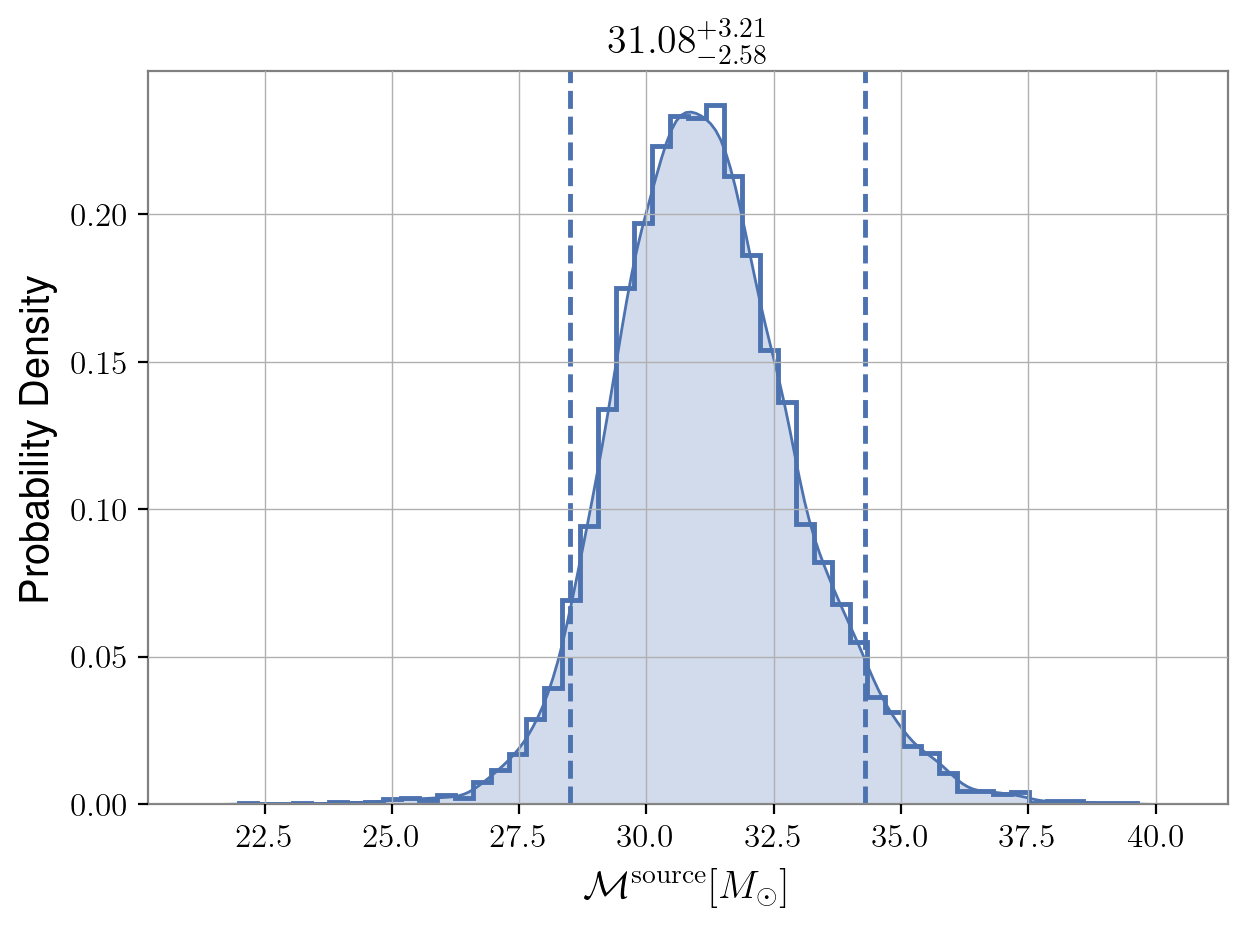

In [16]:
fig = posterior_samples.plot("chirp_mass_source", type="hist", kde=True)

We can also plot combinations of the posterior samples using a [corner plot](https://corner.readthedocs.io/en/latest/). These plots can be useful to spot degeneracies between parameters. Below we use `pesummary` to make a corner plot of four parameters.

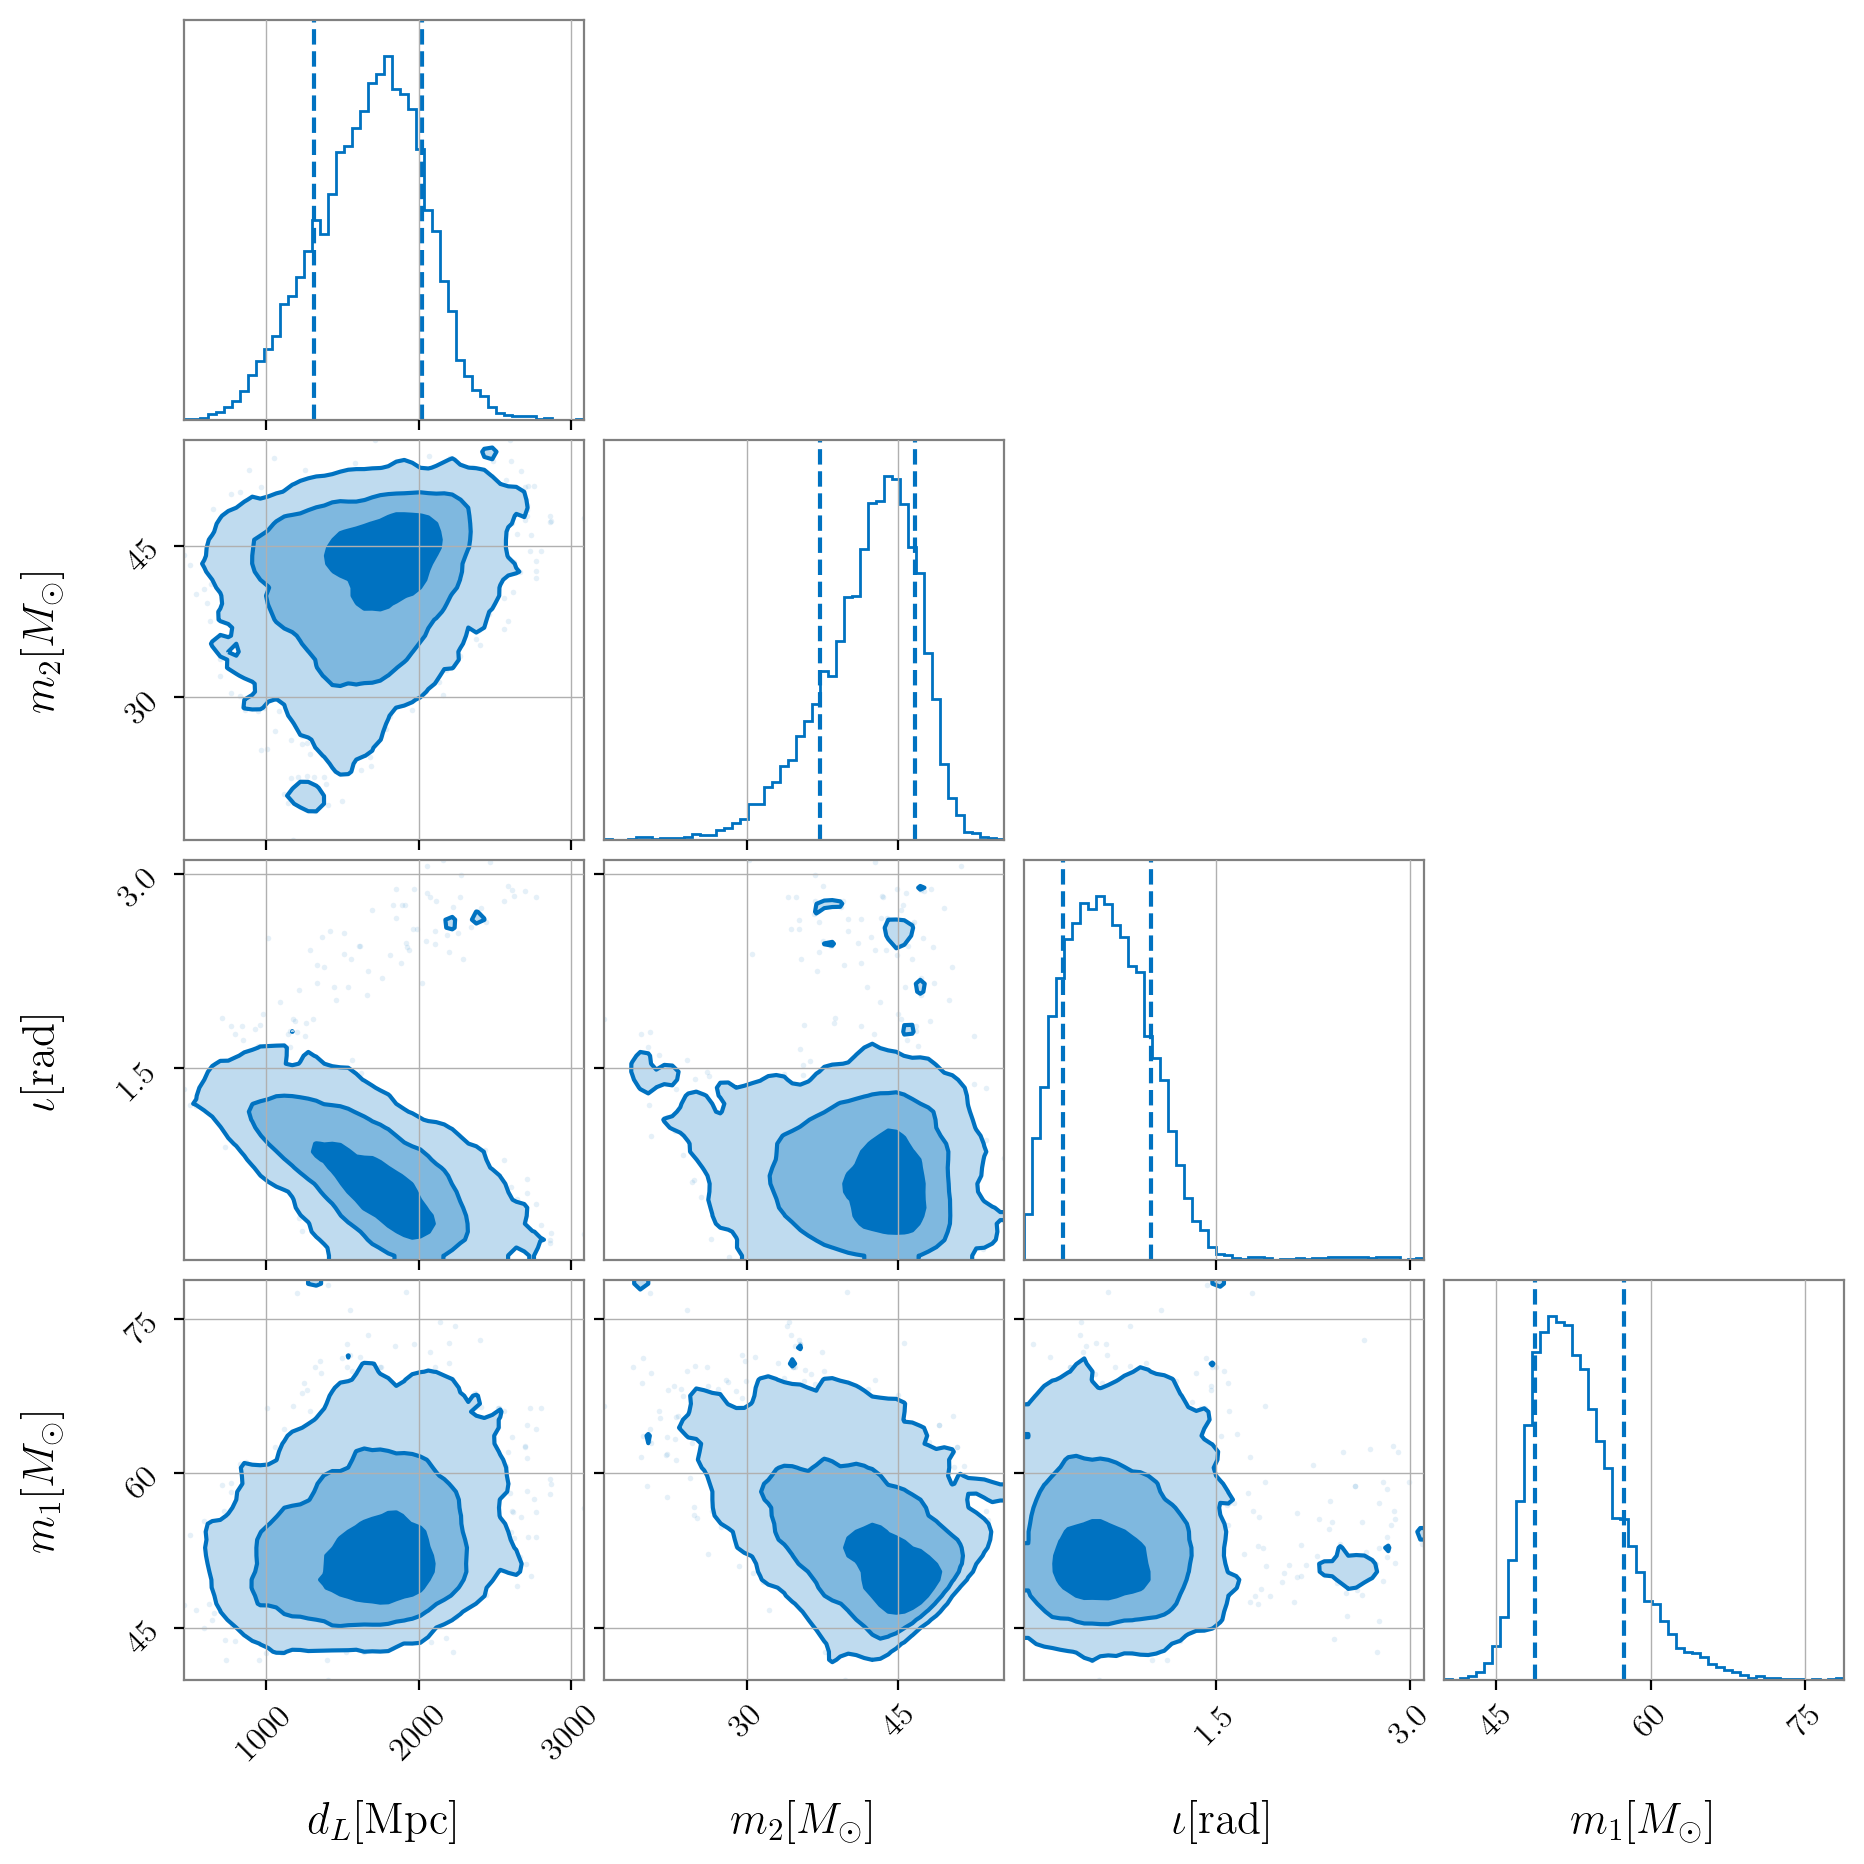

In [17]:
fig = posterior_samples.plot(type="corner",
                             parameters=["mass_1",
                                         "mass_2",
                                         "iota",
                                         "luminosity_distance"])

The spin posteriors can be represented as a spin disk plot. This shows the probable magnitude and direction of the spin vectors for each component black hole.

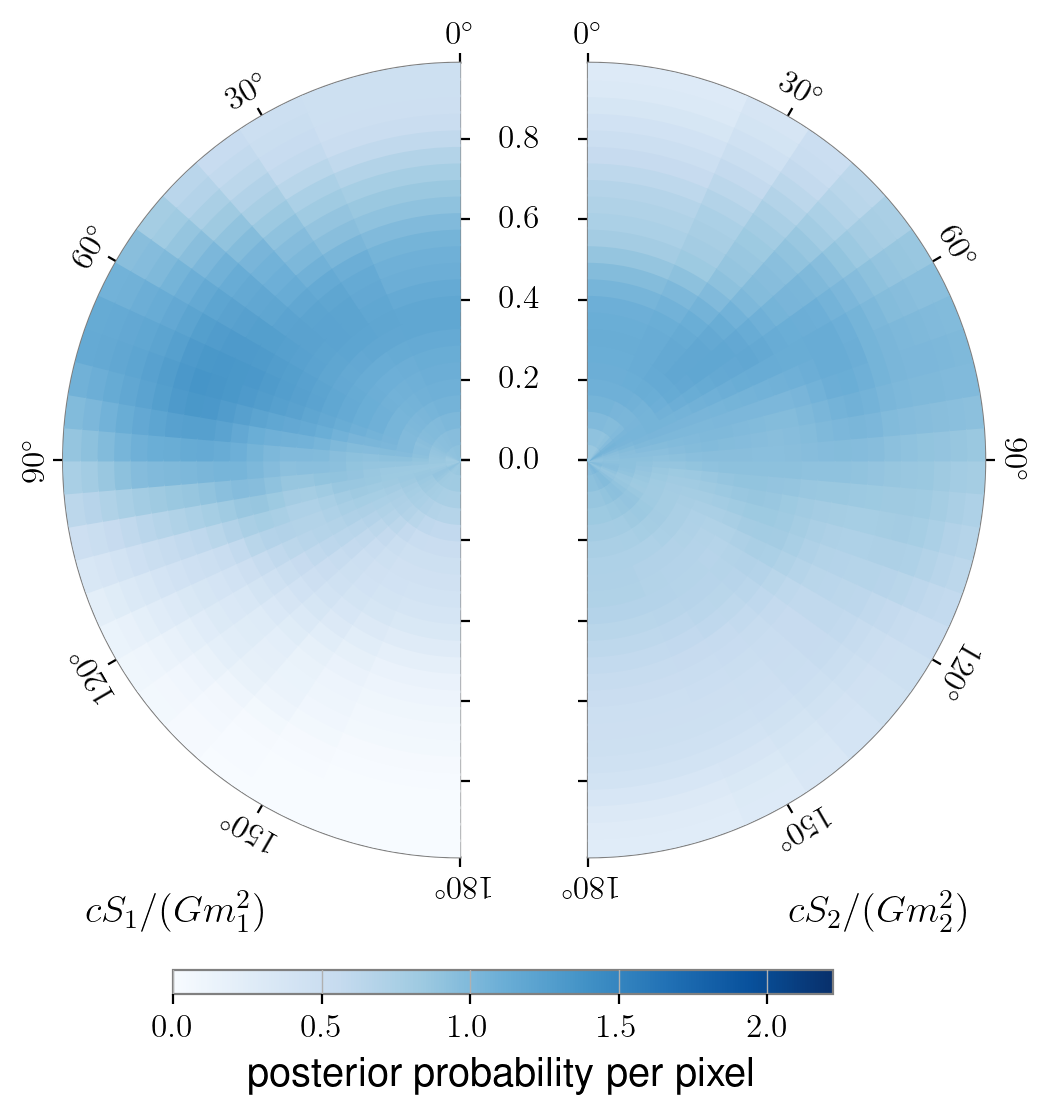

In [18]:
fig = posterior_samples.plot(type="spin_disk", colorbar=True, annotate=False,
                            show_label=True, cmap="Blues")

## Comparing multiple analyses

We can compare two or more sample sets. For example, we show below a comparison of the analyses performed for GW200224_222234, in this case both the two different waveforms `IMRPhenomXPHM` and `SEOBNRv4PHM`. We also compare these to the `C01:Mixed` sample set. First we can consider how the two waveforms compare on sampling the Chirp Mass of GW200224_222234 using a simple histogram

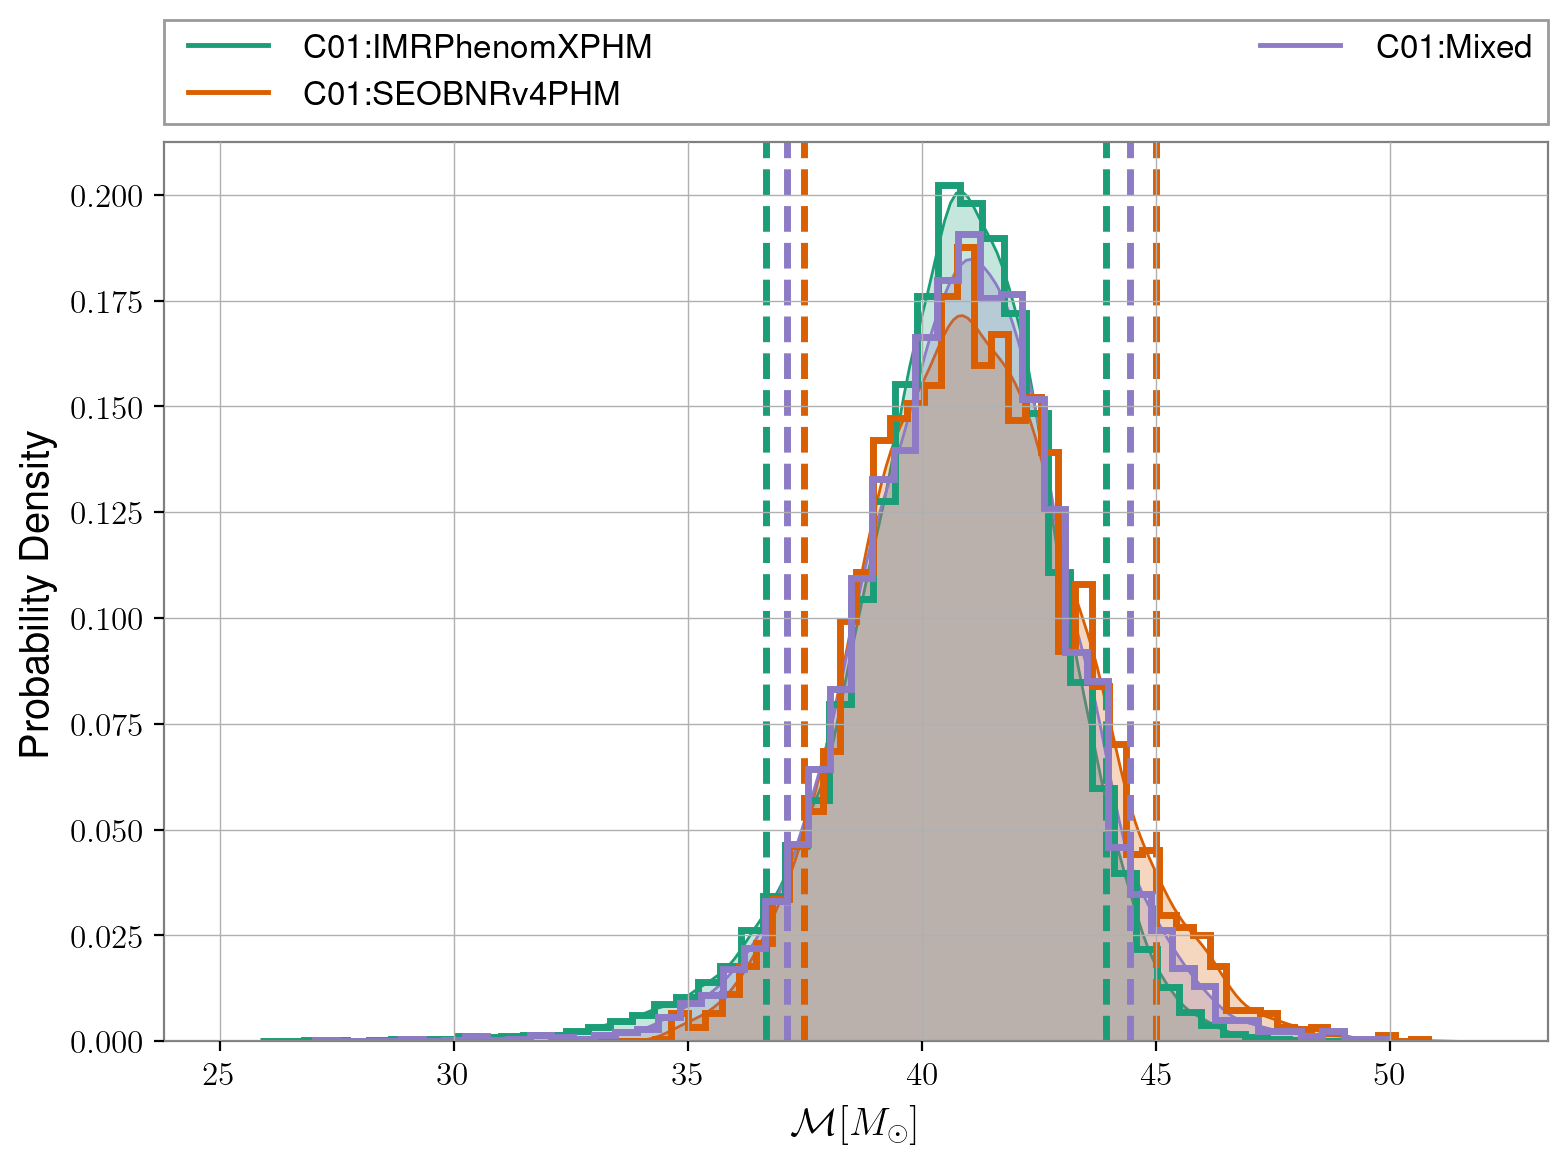

In [19]:
# select color scheme
color_palette = ["#1b9e77", "#d95f02", "#8D7BC5"]

compared_analyses = ["C01:IMRPhenomXPHM", "C01:SEOBNRv4PHM", "C01:Mixed"]
fig = samples_dict.plot("chirp_mass",
                        type="hist",
                        kde=True,
                        labels=compared_analyses,
                        colors=color_palette)

We can also make a violin plot to compare these analyses. The violin plot shows the one-dimensional posterior distribution for a selection of analysis or parameters. It can also be used to compare to the priors of the runs.

Please note: There are no sample priors provided for `C01:SEOBNRv4PHM` due to the nature of the sampler used to generate these samples. The same is true for `C01:Mixed` as it is a combination of two sampling runs. However, we can compare to the priors for the `C01:IMRPhenomXPHM` run as they should have a comparable shape in the distribution. These plotting routines need to access every set of samples for the parameter and then plot, so they can take some time to run.

In [20]:
# Setting the prior samples for the SEOBNRv4PHM and Mixed sets to be those of IMRPhenomXPHM set
data.priors["samples"]["C01:SEOBNRv4PHM"] = data.priors["samples"]["C01:IMRPhenomXPHM"]
data.priors["samples"]["C01:Mixed"] = data.priors["samples"]["C01:IMRPhenomXPHM"]

/home/ADF/middlehr/anaconda3/envs/stenv/lib/python3.10/site-packages/pesummary/core/plots/seaborn/violin.py:774: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _left_label = np.array([[left_label] * len(sample) for sample in left])


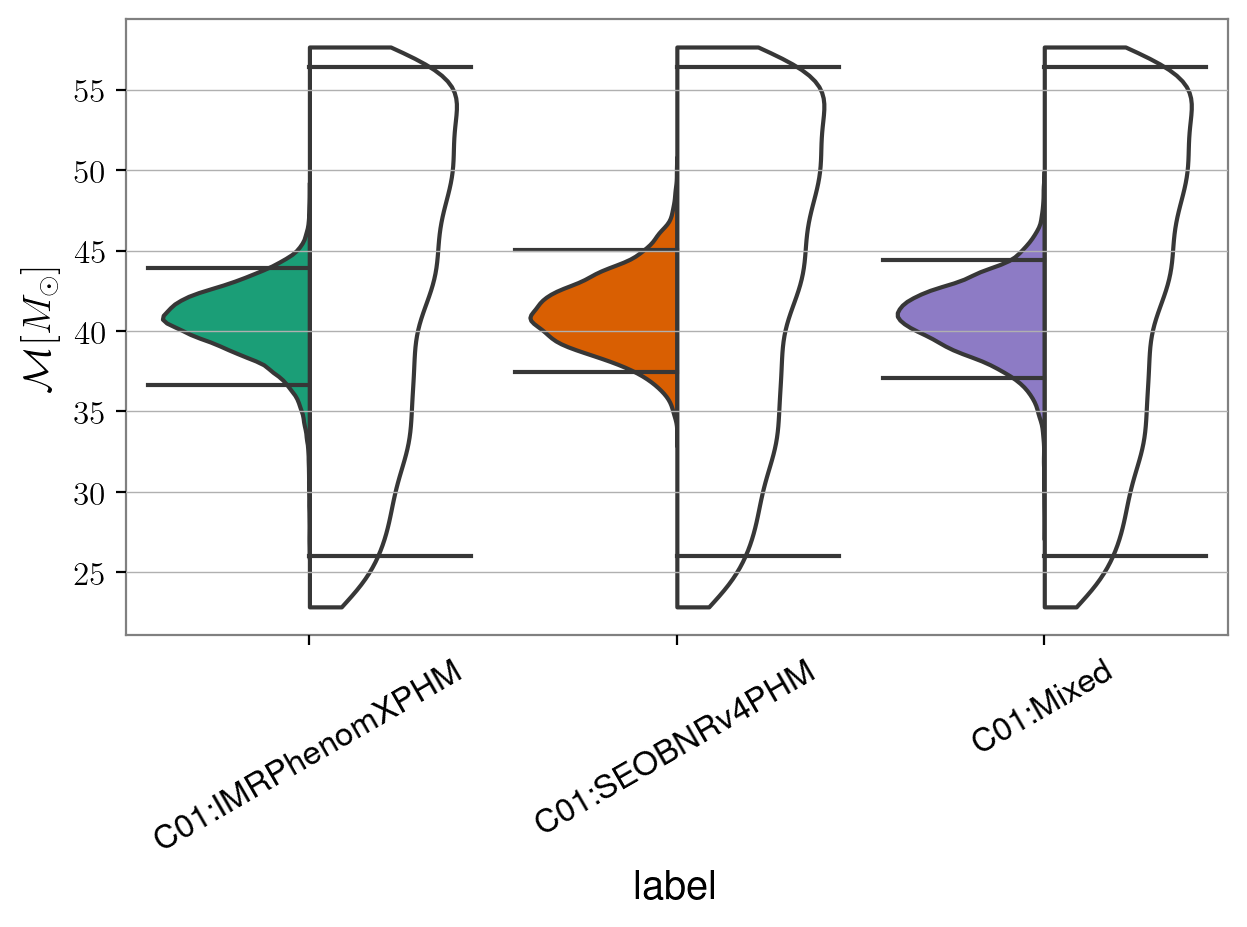

In [21]:
fig = samples_dict.plot("chirp_mass",
                        type="violin",
                        labels=compared_analyses,
                        palette=color_palette,
                        priors=data.priors["samples"])

To compare more than two parameters, we can use a comparison corner plot:

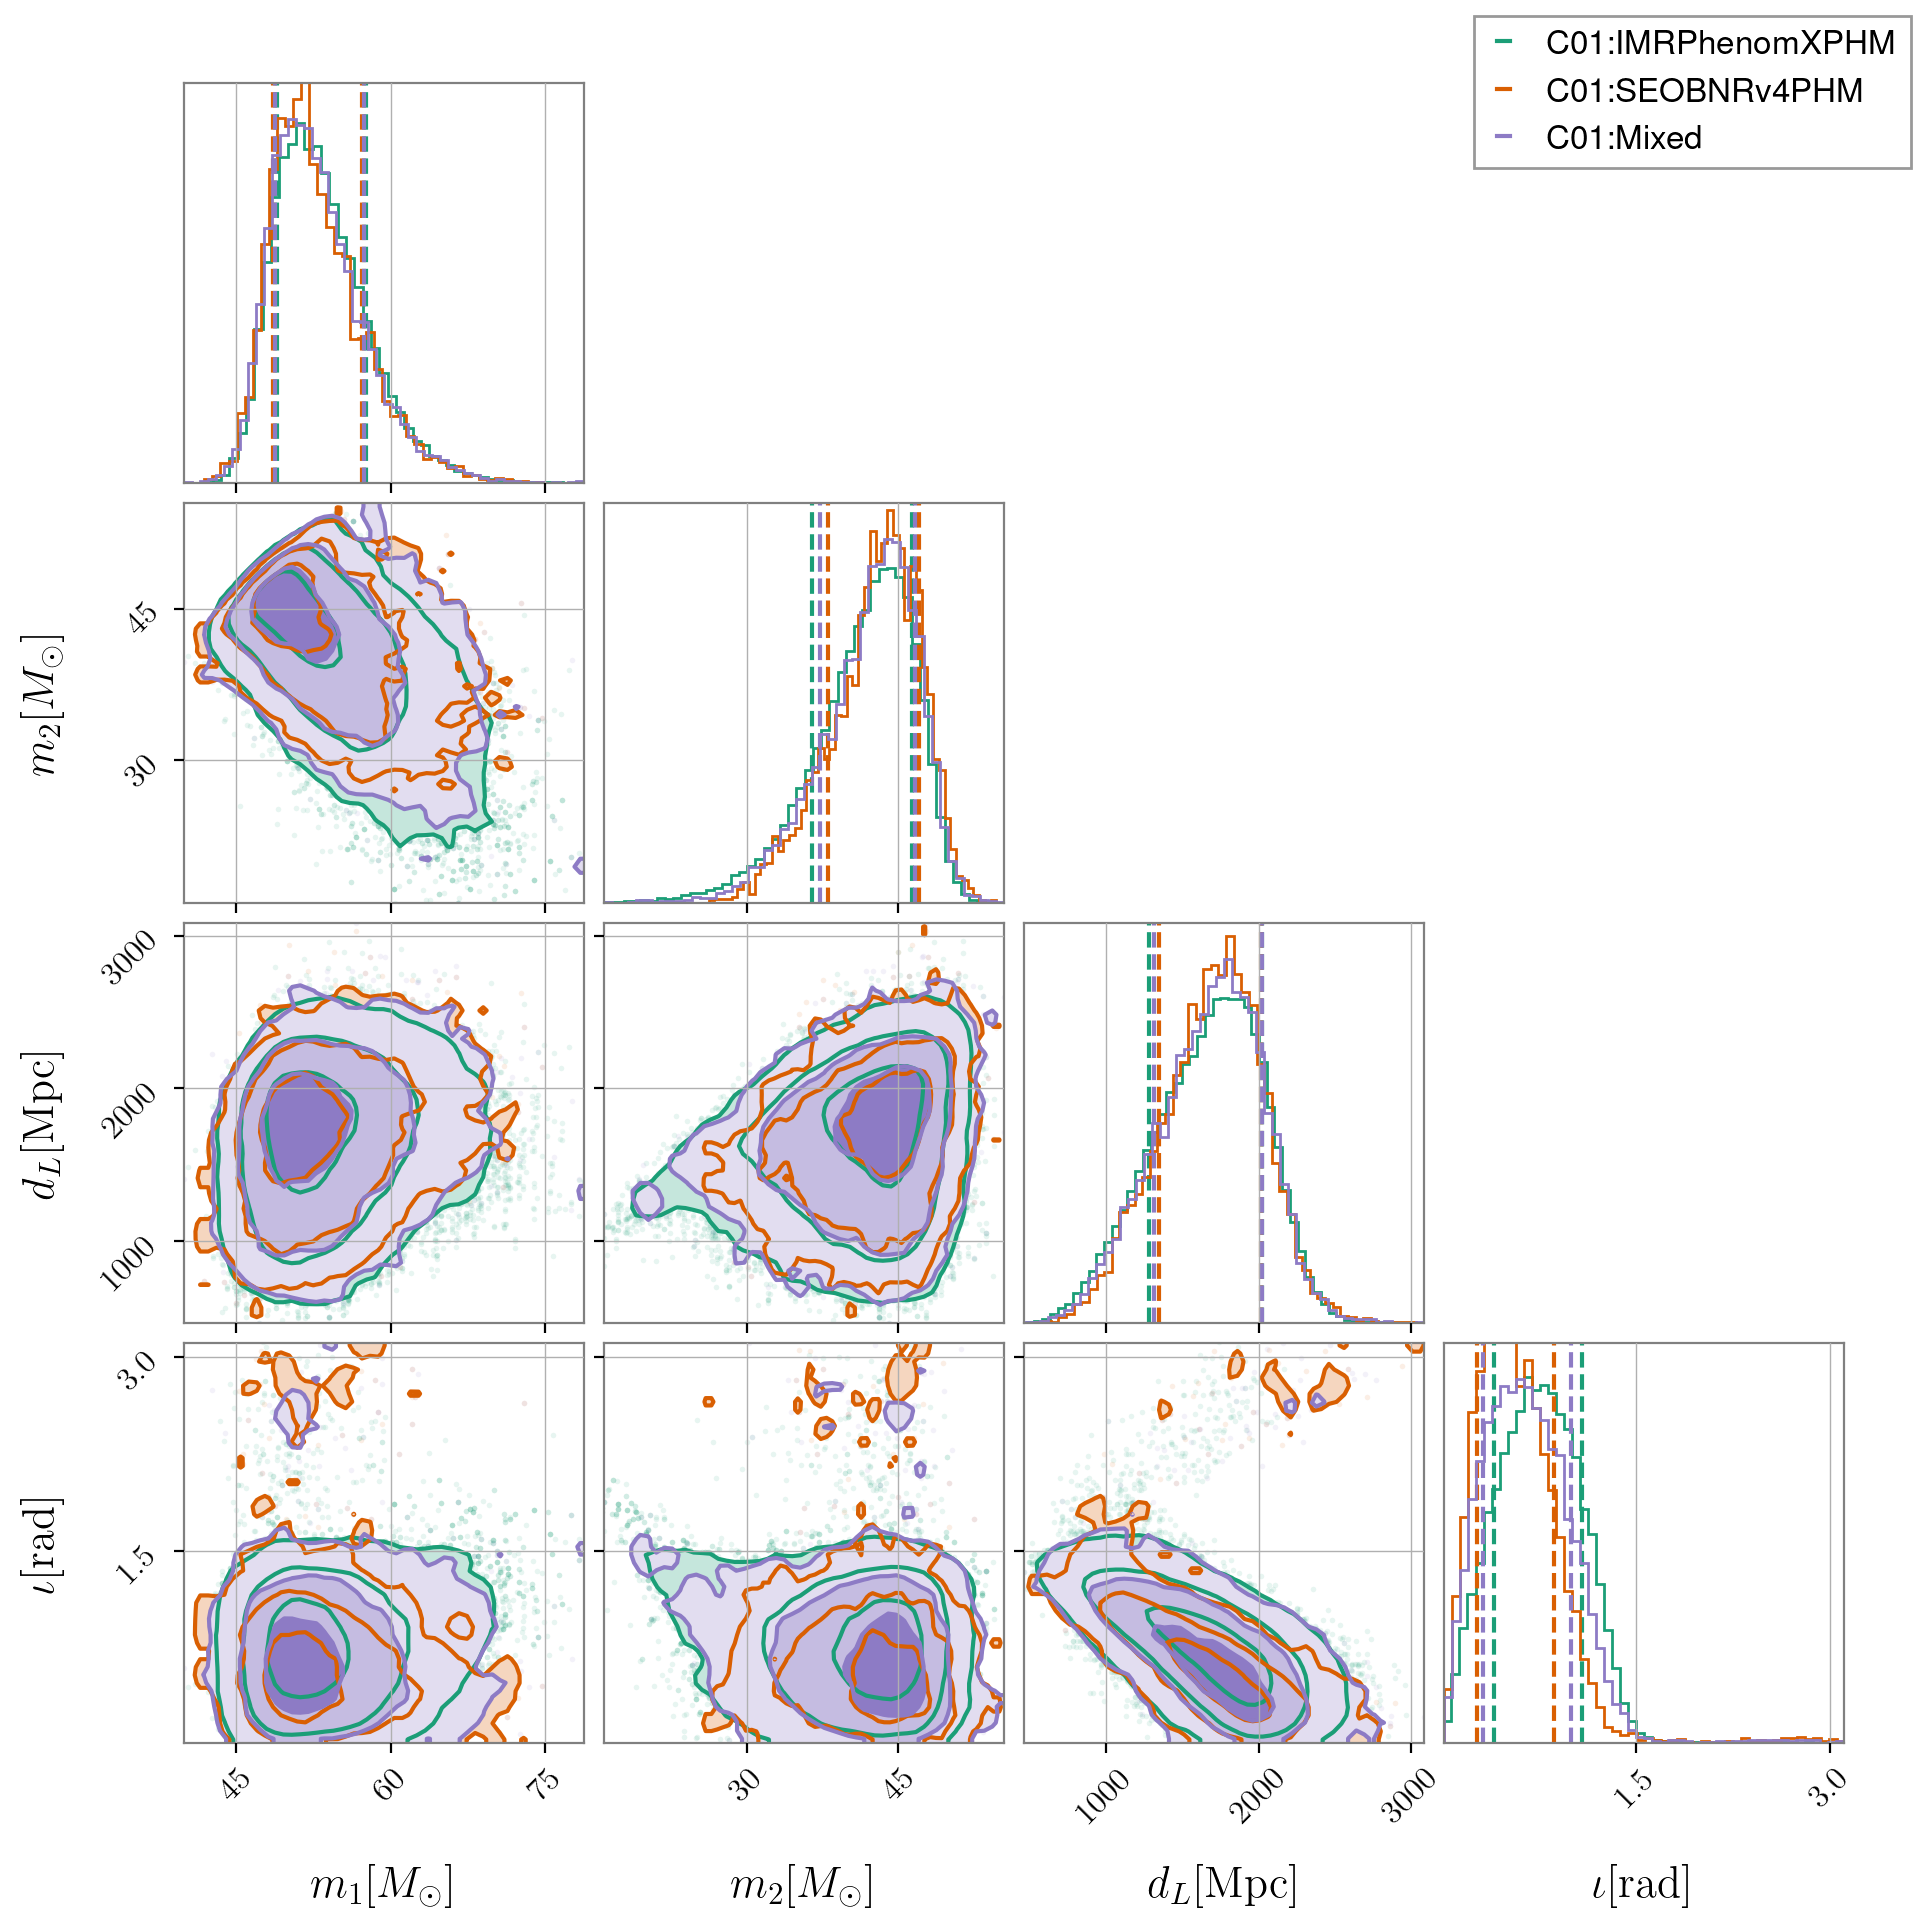

In [22]:
fig = samples_dict.plot(type="corner", 
                        parameters=["mass_1",
                                    "mass_2",
                                    "luminosity_distance",
                                    "iota"],
                        labels=compared_analyses,
                        colors=color_palette)

Triangle plots allow for easy comparison of two parameters across multiple sets of analyses. This next cell may take a long time to run due to the large number of samples. If you remove the `smooth=None` and `module="gw"` it should run faster. These options are added to prevent smoothing over the `q=1` boundary.

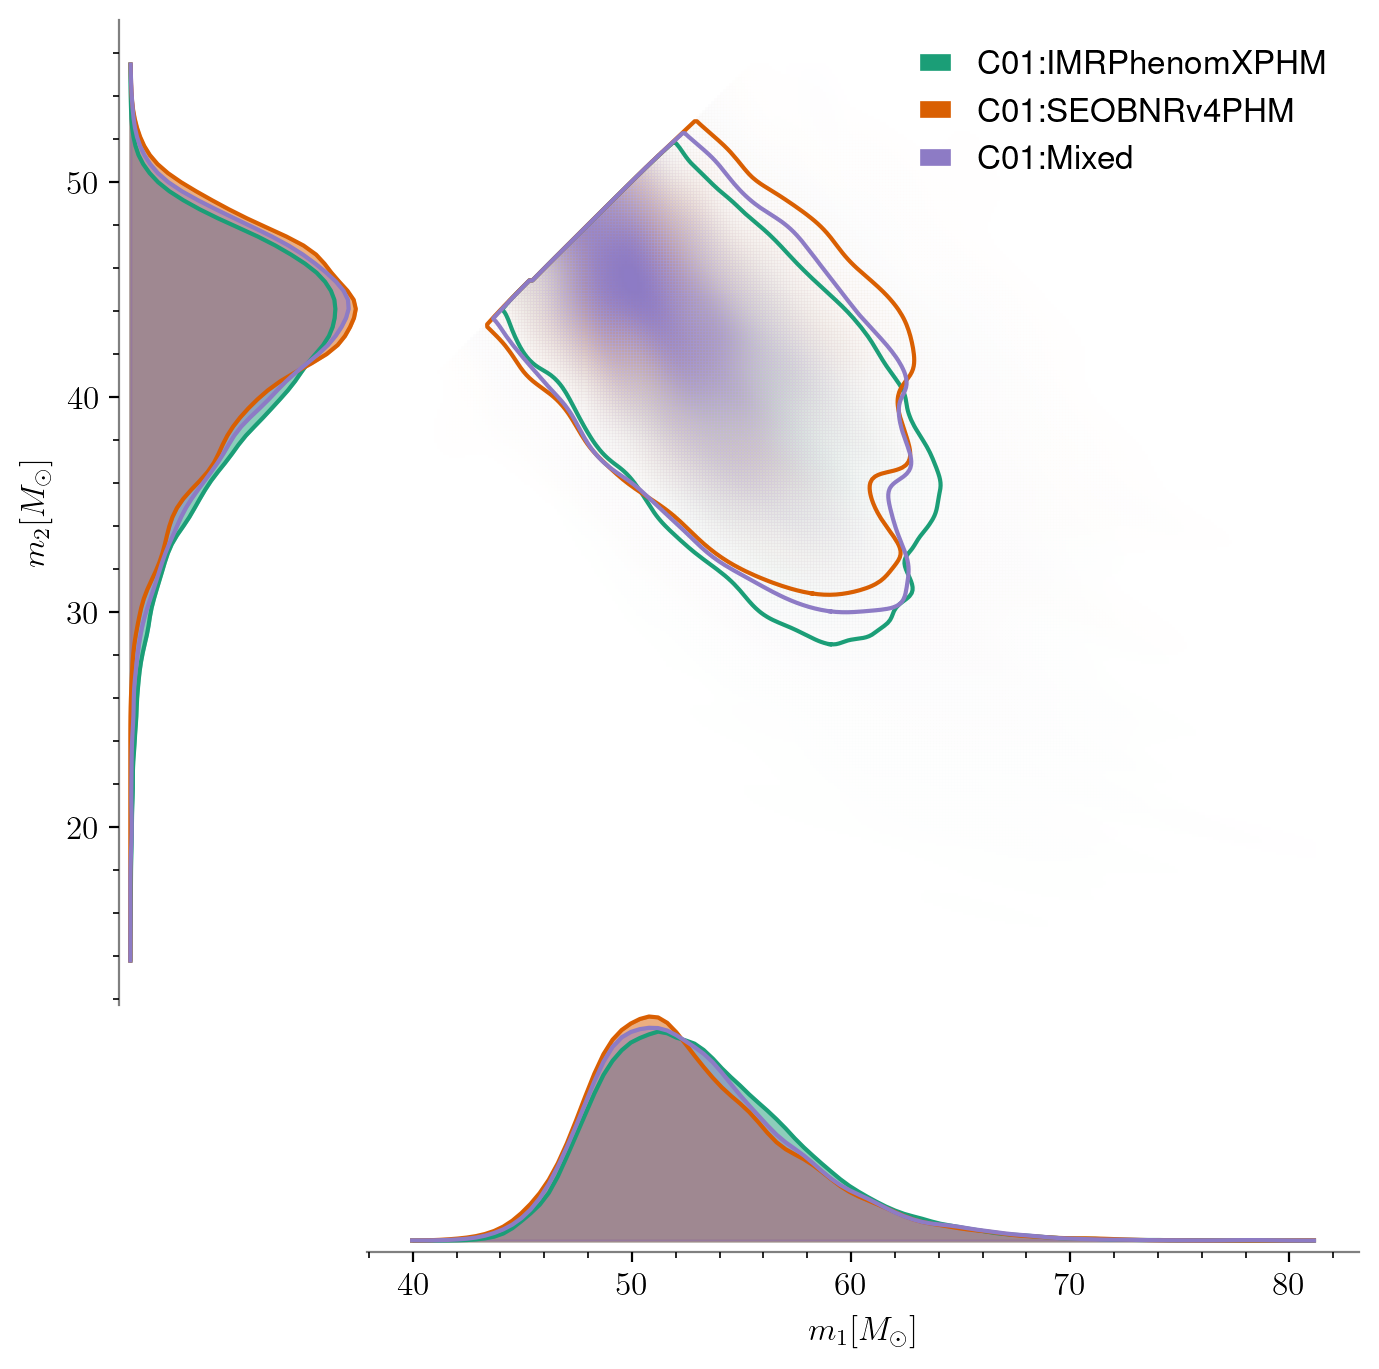

In [23]:
fig = samples_dict.plot(["mass_1", "mass_2"], 
                        type="reverse_triangle",
                        grid=False,
                        smooth=None,
                        module="gw",
                        labels=compared_analyses,
                        shading="auto",
                        colors=color_palette)

## Power Spectral Density (PSD)

The parameter estimation files also store the Power-Spectral-Density (PSD) that was used for each analysis. The PSD represents the noise of the detector at the time of the gravitational wave event. The plot below shows the PSD for the interferometers used for this analysis. In this plot the detectors are represented in the following way:
- H1: LIGO-Hanford
- L1: LIGO-Livingston
- V1: Virgo

(1e-48, 1e-40)

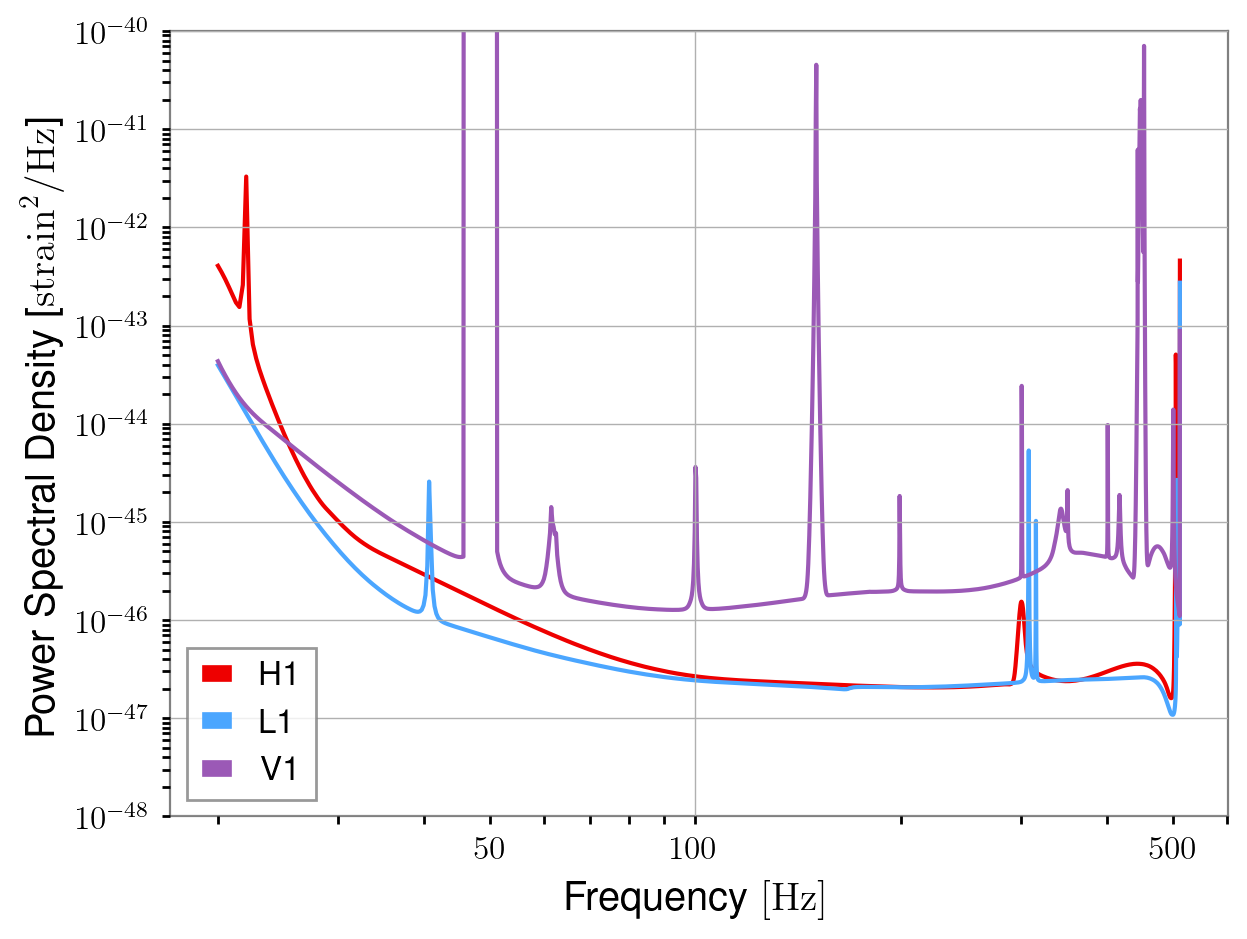

In [24]:
psd = data.psd["C01:IMRPhenomXPHM"]
fig = psd.plot(fmin=20)
ax = fig.gca()
ax.set_ylim(1e-48, 1e-40)

Note: There is a section of the Virgo PSD, between 45 & 50 Hz, which has been gated to avoid a noise source. This can be seen in the PSD plot as the lines that extend up to $10^{-1}$ on the y-axis.

## Skymaps 

The sky location of the event can be shown directly from the pesummary metafile. This will produce a map of the sky with contours showing the specified credible intervals for the position of the event. As this event was found in three detectors, it is very well constrained in sky position. The 90% credible interval can be seen at approximately 12h close to zero degrees.

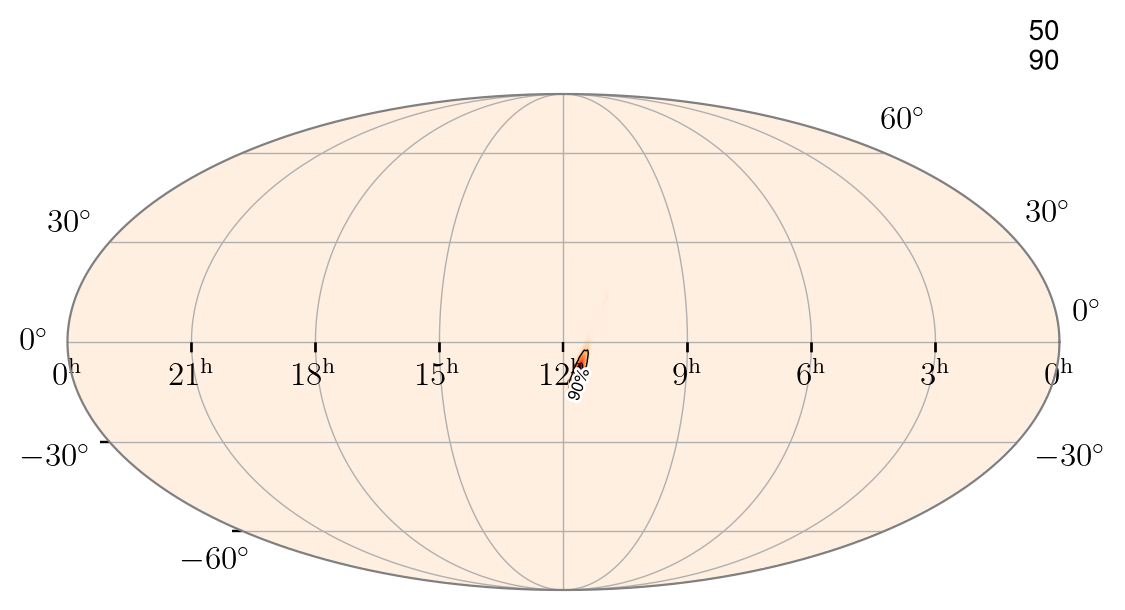

In [25]:
fig = data.skymap["C01:IMRPhenomXPHM"].plot(contour=[50, 90])

As this event was found in three detectors the sky location is quite well resolved. Using the `projection="astro zoom"` argument we can zoom in on this region itself for a clearer view. Depending on the version of `PESummary` installed, this may raise an `UnboundLocalError`, we have wrapped this in a `try-except` statement to avoid showing this error in older versions.

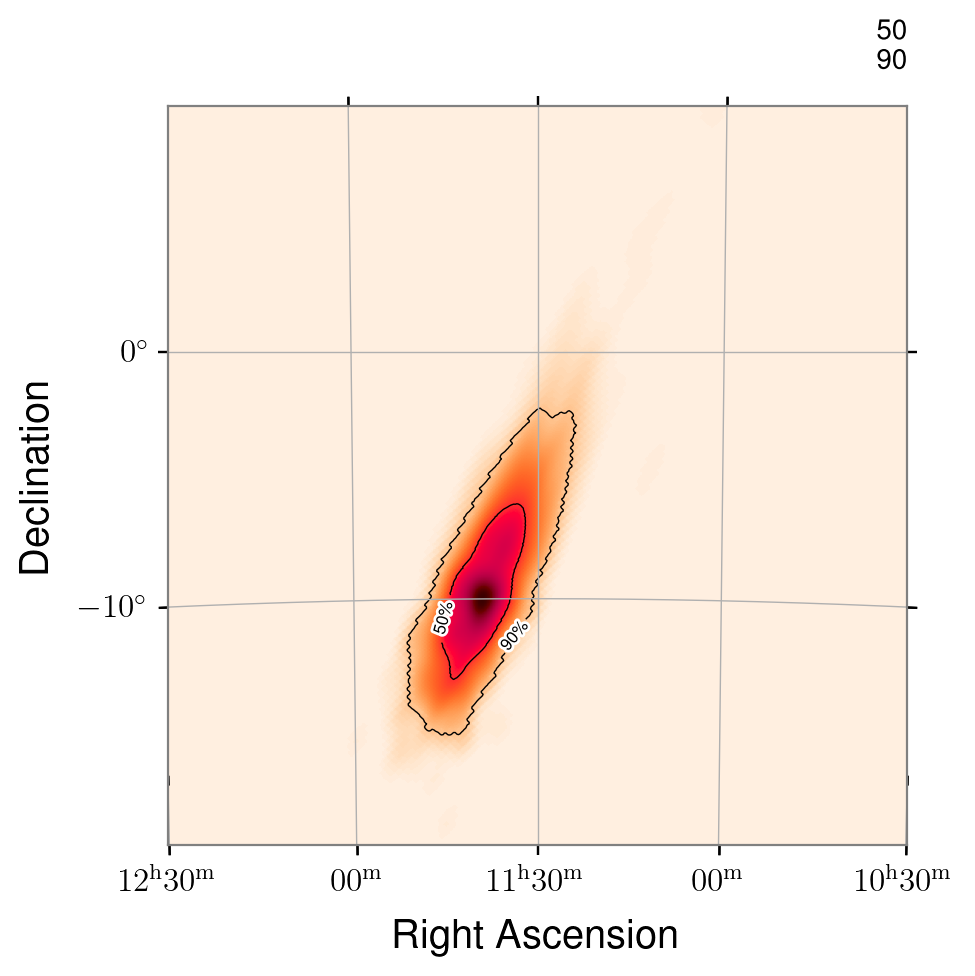

In [26]:
try:
    ax = plt.axes(projection="astro zoom", center="11h 30m -5d", radius="15 deg")
    ax.set_xlabel("Right Ascension")
    ax.set_ylabel("Declination")
    fig = data.skymap["C01:IMRPhenomXPHM"].plot(contour=[50, 90], ax=ax)
except UnboundLocalError:
    pass

## Waveforms

Here we will generate the expected waveform from the sample sets. This allows us to see how the signal appears in the detector. We can generate the waveform from a specific sample using `.td_wavefrom` and the index of the sample you are interested in. This returns a dictionary containing two [`gwpy.timeseries.TimeSeries`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries/) of the plus and cross polarizations of the gravitational wave in the time domain

In [27]:
approximant = "SEOBNRv4PHM"
index = 100
delta_t = 1. / 4096
f_low = 10.
waveforms = samples_dict[f"C01:{approximant}"].td_waveform(approximant, delta_t, f_low, f_ref=f_low, ind=index)

Alternatively, we can use PESummary's [`.maxL_td_waveform`](https://lscsoft.docs.ligo.org/pesummary/stable_docs/gw/tutorials/waveforms.html?highlight=maxl_td_waveform) method to produce the waveform from the sample with the largest likelihood. The time samples for the `SEOBNRv4PHM` runs were not recovered by the sampler, so we will now set these to that of the maximum likelihood merger time from the `IMRPhenomXPHM` run.

In [28]:
Nsamples = samples_dict["C01:SEOBNRv4PHM"].number_of_samples
samples_dict[f"C01:{approximant}"]["geocent_time"] = samples_dict[f"C01:IMRPhenomXPHM"].maxL["geocent_time"][0] * np.ones(Nsamples)

In [29]:
waveforms = samples_dict[f"C01:{approximant}"].maxL_td_waveform(approximant, delta_t, f_low, f_ref=f_low)

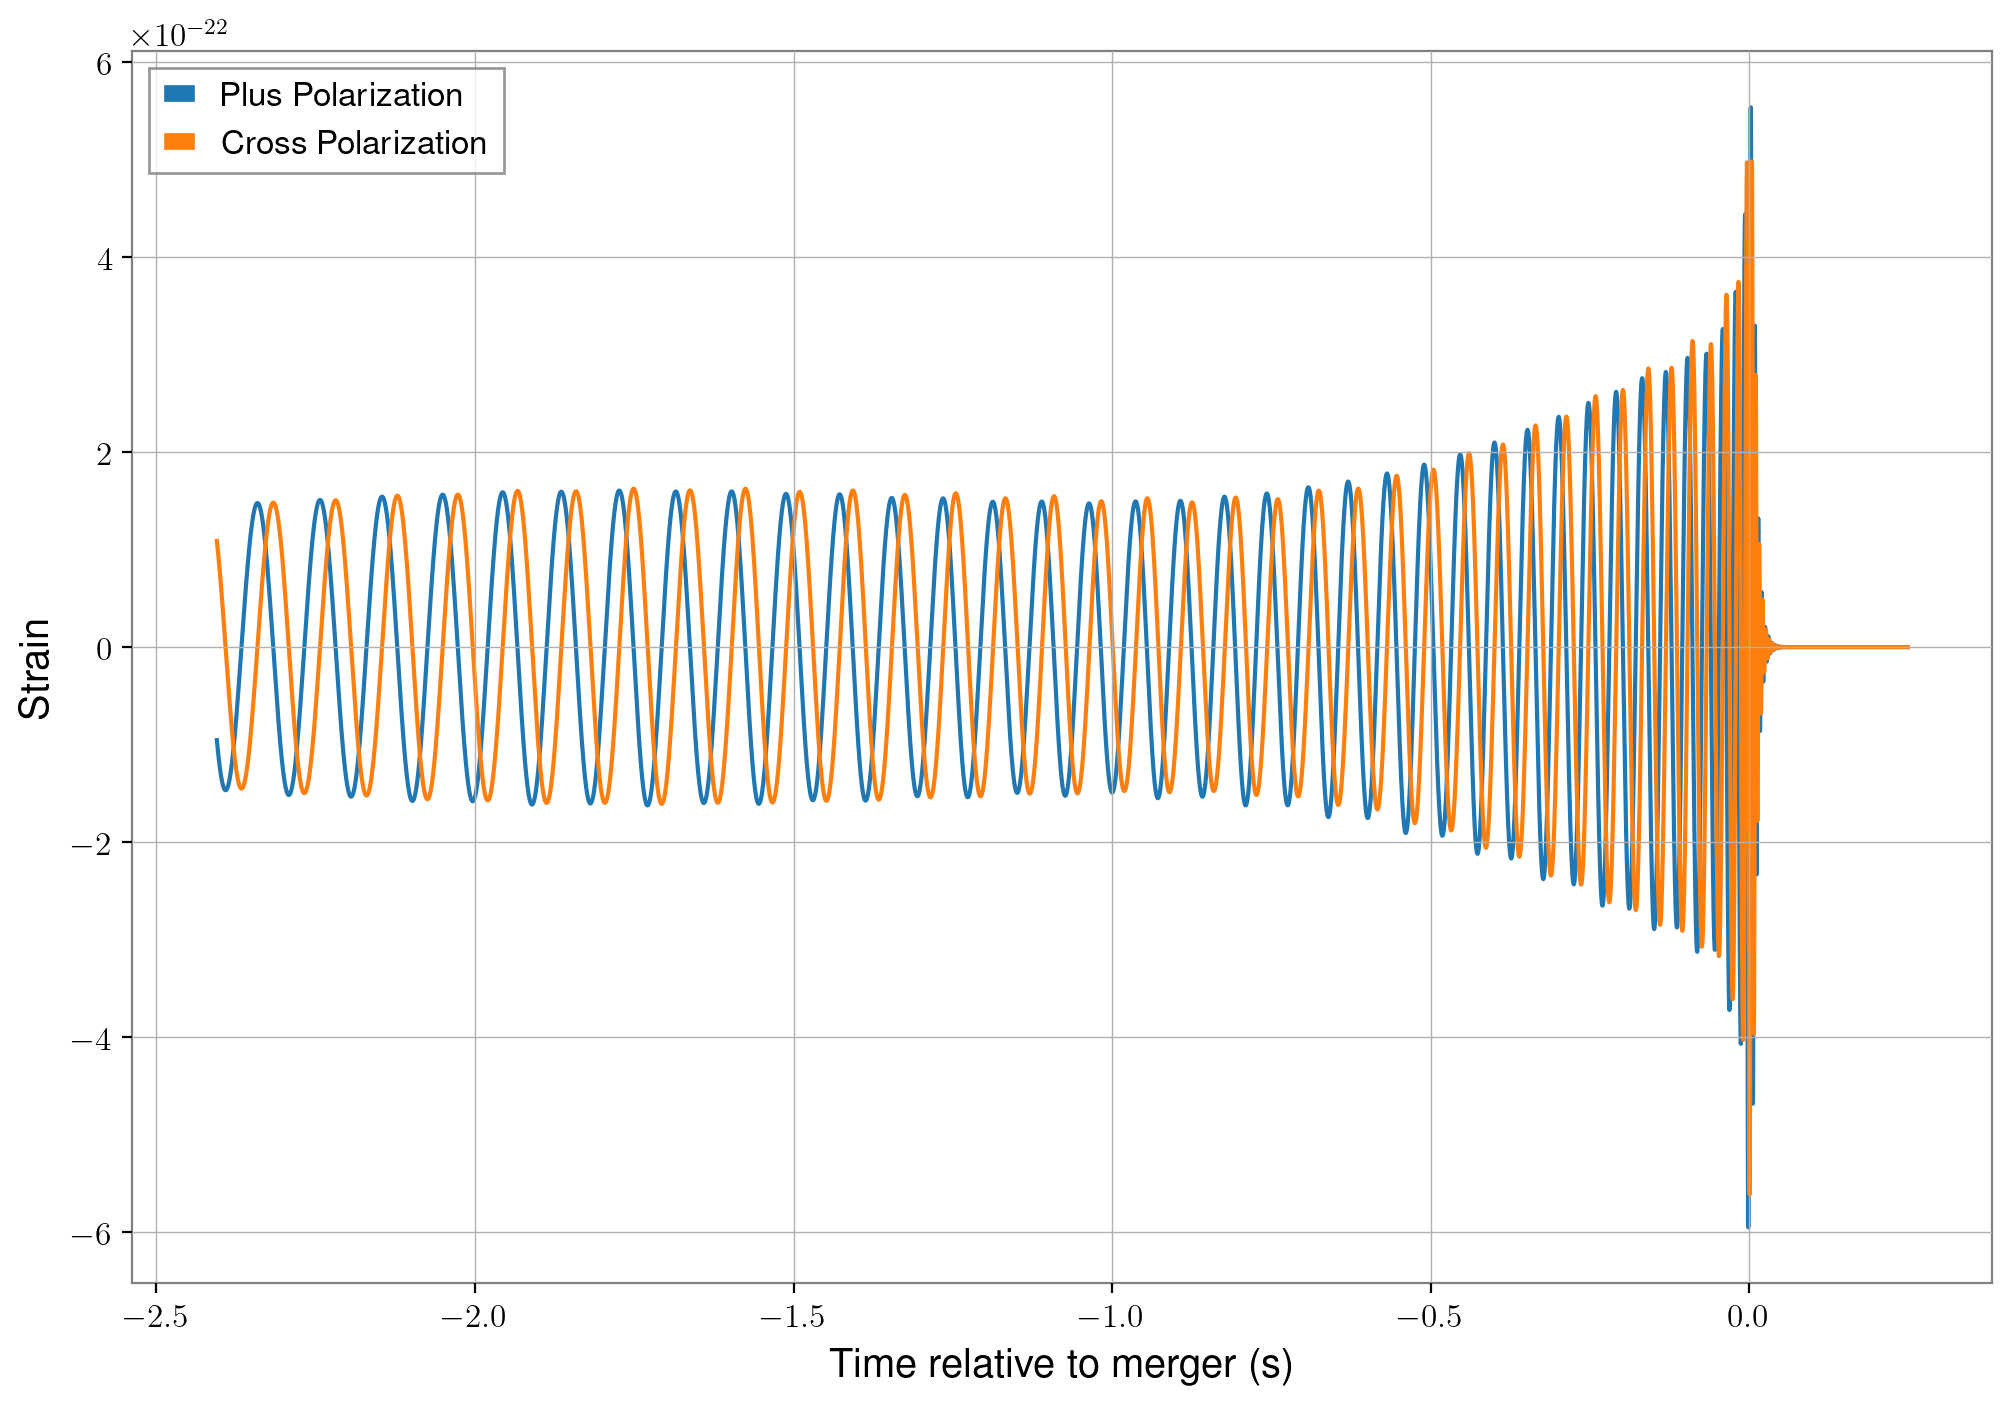

In [30]:
fig = plt.figure(figsize=(12,8))
plt.plot(waveforms["h_plus"].times, waveforms["h_plus"], label="Plus Polarization")
plt.plot(waveforms["h_cross"].times, waveforms["h_cross"], label="Cross Polarization")
plt.xlabel("Time relative to merger (s)")
plt.ylabel("Strain")
plt.legend()
plt.show()
plt.close()

We can then project these into specific detectors to observe how they appear in the strain data. This utilises the antenna response function of the requested detector. 

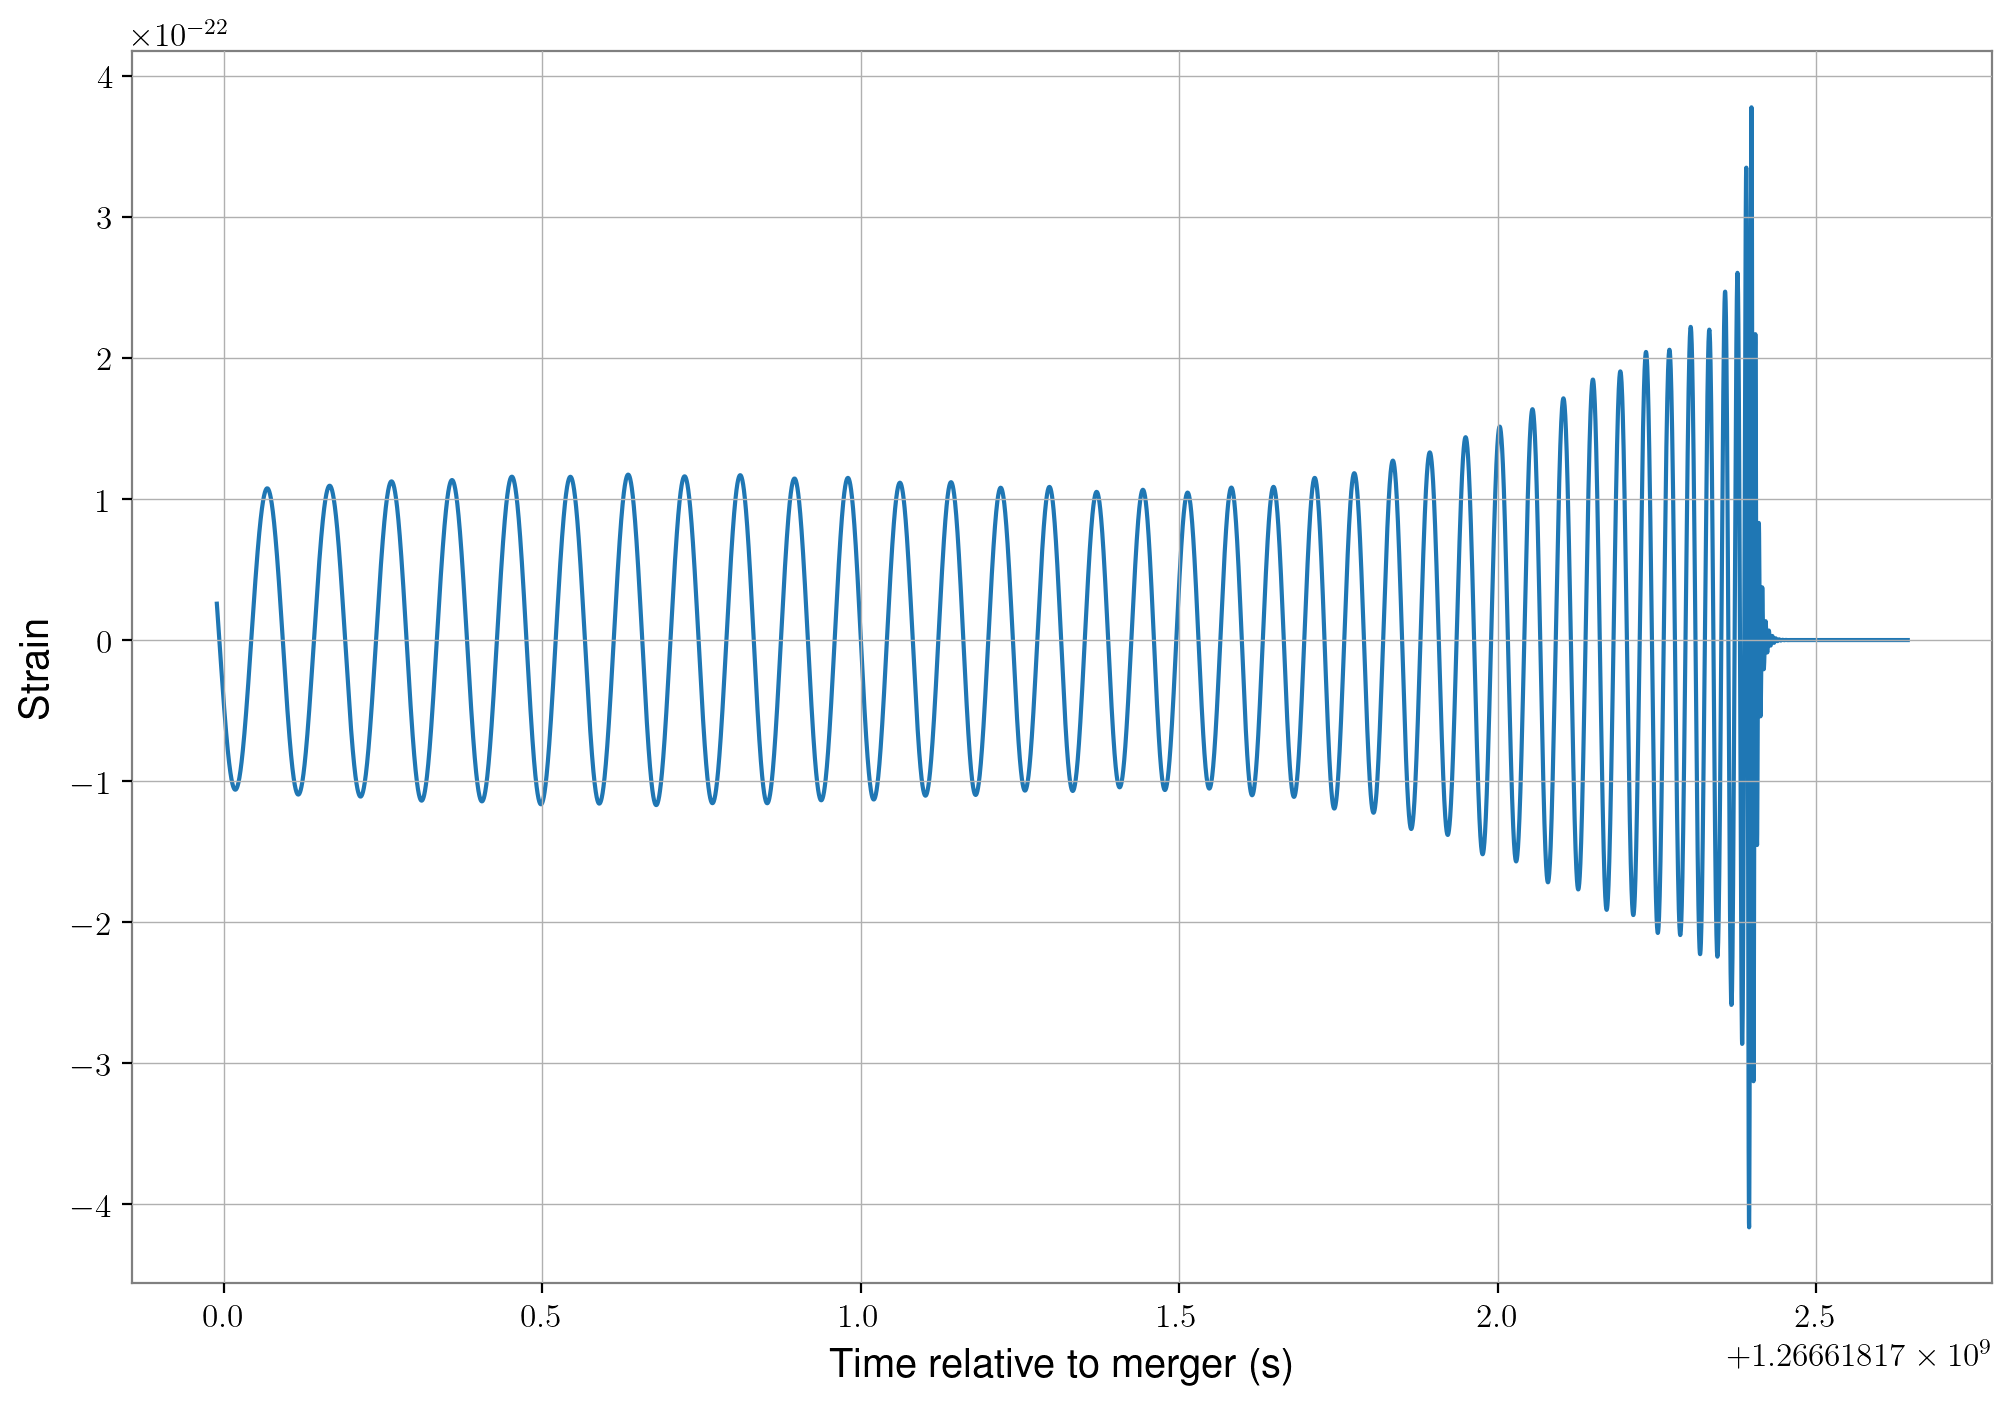

In [31]:
maxL_projected_waveform = samples_dict[f"C01:{approximant}"].maxL_td_waveform(approximant, delta_t, f_low, f_ref=f_low, project="L1")
fig = plt.figure(figsize=(12,8))
plt.plot(maxL_projected_waveform.times, maxL_projected_waveform)
plt.xlabel("Time relative to merger (s)")
plt.ylabel("Strain")
plt.show()
plt.close()

The times shown above are given in the GPS time format as standard across LVK results. GPS time is defined as the number of seconds that have elapsed since midnight (00:00 UTC) on January 1st 1980. There are several methods to convert this to a human readable time; GWOSC provides a [GPS time converter](https://www.gw-openscience.org/gps/) you can use to translate into datetime, alternatively there are several Python routines including [`gwpy.time`](https://gwpy.github.io/docs/stable/time/).

In [32]:
import gwpy
merger_time = samples_dict[f"C01:IMRPhenomXPHM"].maxL["geocent_time"]
merger_time_UTC = gwpy.time.from_gps(merger_time).strftime("%H:%M:%S %d/%m/%Y")
print(merger_time_UTC)

'22:22:34 24/02/2020'

## Detector Strain Data

Raw detector data for each event can be found via the [Gravitational Wave Open Science Centre (GWOSC)](https://www.gw-openscience.org). We can then check this data for signals and compare to our waveforms to see how consistent the results of our parameter estimation are with the true data. We can find the segments containing the data directly using the [gwosc](https://gwosc.readthedocs.io/en/latest/locate.html) python package. Or using [PESummary's `fetch_open_strain` method](https://docs.ligo.org/lscsoft/pesummary/stable_docs/gw/fetch.html). This will load the strain data as a [`pesummary.gw.file.strain.StrainData` object](https://lscsoft.docs.ligo.org/pesummary/stable_docs/gw/strain.html). This inherits directly from the [`gwpy.timeseries.TimeSeries` class](https://gwpy.github.io/docs/stable/timeseries/index.html)

First we import `PESummary` functions needed to get the strain data and manipulate our templates to fit the data

In [33]:
from pesummary.gw.fetch import fetch_open_strain
from pesummary.gw.file.strain import StrainData

The next cell allows us to load the strain data directly from GWOSC, through `PESummary`. The GWOSC website, linked above, will also allow you to directly download the strain data at different sampling rates. This can then be loaded using the `StrainData.read()` method shown below, commented out.

In [34]:
# Load strain
strain_data = fetch_open_strain("GW200224_222234", IFO="L1", duration=32, sampling_rate=4096, read_file=True, channel="L1:GWOSC-4KHZ_R1_STRAIN")
#strain_data = StrainData.read("L-L1_GWOSC_4KHZ_R1-1266618157-32.gwf", channel="L1:GWOSC-4KHZ_R1_STRAIN", IFO="L1")

Now we will make a copy of our maximum likelihood template which prevents the true waveform being modified by the plotting methods. We will also calculate the expected merger time by taking the `L1_time` parameter from the `IMRPhenomXPHM` sample set. This parameter is the sampler calculated time of merger in the Livingston detector.

In [35]:
template = maxL_projected_waveform.copy()
L1_time = samples_dict[f"C01:IMRPhenomXPHM"].maxL["L1_time"][0]

Now we can plot a comparison of this signal with the detector data. The data is given with only the frequencies between 40 & 350 Hz to represent Livingston's sensitive region. We see an offset between the maxL waveform and strain data because, as noted above, there are no time samples for the SEOBNRv4PHM samples.

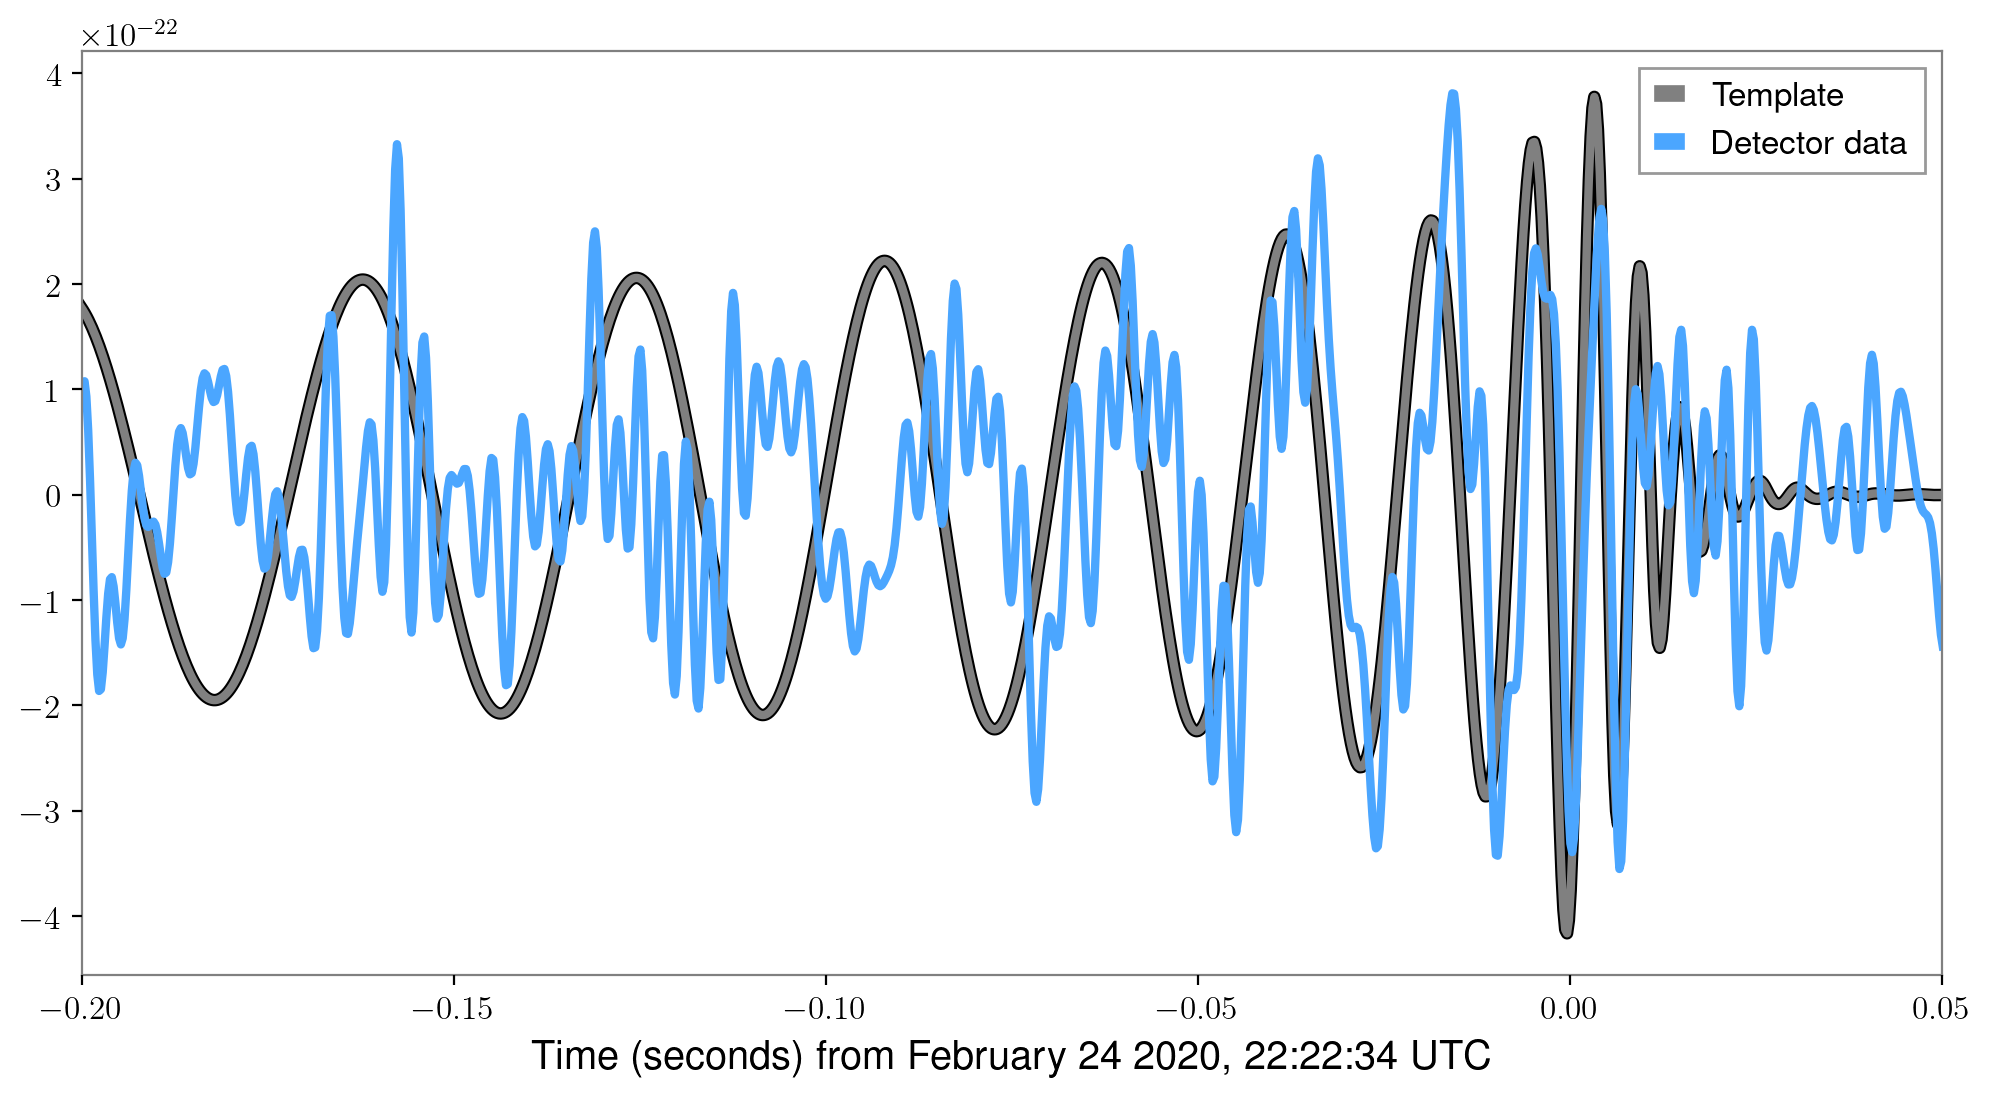

In [36]:
# Plot comparison
fig = strain_data.plot(
    type="td",
    merger_time=L1_time,
    window=(-0.2, 0.05),
    template={"L1": template}, bandpass_frequencies=[40., 350.]
)
plt.show()
fig.close()